In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import random

from placement_rl.baseline import exhaustive, random_placement, heft, random_op_greedy_dev, random_op_est_dev, get_placement_constraints
from os import listdir
from os.path import isfile, join
from env.utils import generate_graph, generate_network
from env.network import StarNetwork, FullNetwork
from env.program import Program
from env.latency import evaluate, computation_latency, communication_latency, simulate

from placement_rl.placement_agent import PlacementAgent

import os, itertools
import pickle, json

import time


Using backend: pytorch


In [2]:
def get_eval_cases(logdir):    
    networks, programs = pickle.load(open(join(logdir, 'eval_data.pkl'), 'rb'))
    run_data =  json.load(open(join(logdir, 'run_data.txt'), 'r'))
    n_id, p_id, init_map = [s[0] for s in run_data['eval_sequence']], [s[1] for s in run_data['eval_sequence']], [s[2] for s in run_data['eval_sequence']]
    
    norm_serial_min = []
    norm_serial_avg = []
    norm_cp = []
    
    for program_id, network_id in zip(p_id, n_id):
        
        prg = programs[program_id]
        net = networks[network_id]

        constraints = get_placement_constraints(prg, net)

        comp_min = []
        comm_min = []

        comp_a = []
        comm_a = []

        for n in prg.P.nodes():
            comp_t = [computation_latency(prg, net, n, dev) for dev in constraints[n]]
            comp_min.append(min(comp_t))
            comp_a.append(np.mean(comp_t))
            for e in prg.P.out_edges(n):
                prg.P.edges[e]['weight'] = min(comp_t)

        for e in prg.P.edges():
            d1 = constraints[e[0]]
            d2 = constraints[e[1]]
            comm_t = [communication_latency(prg, net, e[0],e[1], dev1, dev2) for dev1 in d1 for dev2 in d2]
            comm_min.append(min(comm_t))
            comm_a.append(np.mean(comm_t))
        norm_serial_min.append(np.sum(comp_min) + np.sum(comm_min))
        norm_serial_avg.append(np.sum(comp_a) + np.sum(comm_a))
        norm_cp.append(nx.shortest_path_length(prg.P, source=0, target=prg.P.number_of_nodes()-1, weight='weight').item() + comp_min[-1])
    norm_cp = [a.item() for a in norm_cp]
    return p_id, n_id, init_map, programs, networks, norm_serial_min, norm_serial_avg, norm_cp

giph='GiPH'
opRL = 'RL op, est dev'
placeto = 'Placeto'

markers = {giph: '*', 
           opRL: '+',
           placeto: 'd'}

names = [giph, opRL, placeto]

logdir='runs/single_network/2022-05-10_18-45-59_opdevRL'
logdir_p = 'runs/single_network/2022-05-10_18-46-25_placeto'
logdir_op = 'runs/single_network/2022-05-10_18-46-12_opRL'

# logdir='runs/single_network_noise_5/2022-05-11_22-37-57_opdevRL'
# logdir_p = 'runs/single_network_noise_5/2022-05-11_22-35-44_placeto'
# logdir_op = 'runs/single_network_noise_5/2022-05-11_22-37-09_opRL'

# logdir='runs/single_network_noise_10/2022-05-11_22-39-37_opdevRL'
# logdir_p = 'runs/single_network_noise_10/2022-05-11_22-39-02_placeto'
# logdir_op = 'runs/single_network_noise_10/2022-05-11_22-40-08_opRL'

# logdir='runs/single_network_noise_20/2022-05-12_03-53-47_opdevRL'
# logdir_p = 'runs/single_network_noise_20/2022-05-12_03-54-43_placeto'
# logdir_op = 'runs/single_network_noise_20/2022-05-12_03-54-20_opRL'

logdir='runs/multiple_networks/2022-05-12_22-27-37_devopRL'
logdir_p = 'runs/multiple_networks/2022-05-13_13-57-38_placeto'
logdir_op = 'runs/multiple_networks/2022-05-12_22-27-11_opRL'
p_id, n_id, init_map, programs, networks, norm_serial_min, norm_serial_avg, norm_cp = get_eval_cases(logdir)
p_id1, n_id1, init_map1, programs1, networks1, norm_serial_min1, norm_serial_avg1, norm_cp1 = get_eval_cases(logdir_p)
p_id2, n_id2, init_map2, programs2, networks2, norm_serial_min2, norm_serial_avg2, norm_cp2 = get_eval_cases(logdir_op)

print(torch.sum(torch.absolute(networks[0].comp_rate-networks1[0].comp_rate)))
print(torch.sum(torch.absolute(networks[0].comm_delay-networks1[0].comm_delay)))
print(torch.sum(torch.absolute(networks[0].comm_rate-networks1[0].comm_rate)))
print(torch.sum(torch.absolute(networks[0].comp_rate-networks2[0].comp_rate)))
print(torch.sum(torch.absolute(networks[0].comm_delay-networks2[0].comm_delay)))
print(torch.sum(torch.absolute(networks[0].comm_rate-networks2[0].comm_rate)))

print(torch.sum(torch.absolute(programs[0].op_compute-programs2[0].op_compute)))
print(torch.sum(torch.absolute(programs[0].data_bytes-programs2[0].data_bytes)))
print(torch.sum(torch.absolute(programs2[0].op_compute-programs1[0].op_compute)))
print(torch.sum(torch.absolute(programs2[0].data_bytes-programs1[0].data_bytes)))

# eval_datas = [pickle.load(open(join(ld, 'eval.pk'), 'rb')) for ld in [logdir,logdir_p, logdir_op]]
logs = [logdir, logdir_op, logdir_p]
eval_datas = [pickle.load(open(join(ld, 'eval.pk'), 'rb')) for ld in logs]


tensor(0.2911, dtype=torch.float64)
tensor(2612.1210, dtype=torch.float64)
tensor(0.2426, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [3]:
heft_time = []
heft_lat = []
for test_program, test_network in zip (p_id, n_id):
    prg = programs[test_program]
    net = networks[test_network]
    t = time.time()
    _, l = heft(prg, net)
    heft_time.append([prg.n_operators, net.n_devices, time.time()-t])
    print(heft_time[-1])
    heft_lat.append(l)

[34, 20, 38.891186237335205]
[31, 20, 4.434432029724121]
[20, 20, 1.180544137954712]
[36, 20, 40.06485605239868]
[38, 20, 1560.5657629966736]
[25, 20, 0.2864069938659668]
[22, 20, 7.909800052642822]
[33, 20, 19.985143184661865]
[33, 20, 13.89828610420227]
[22, 20, 0.24902892112731934]


KeyboardInterrupt: 

P77, N2, S20


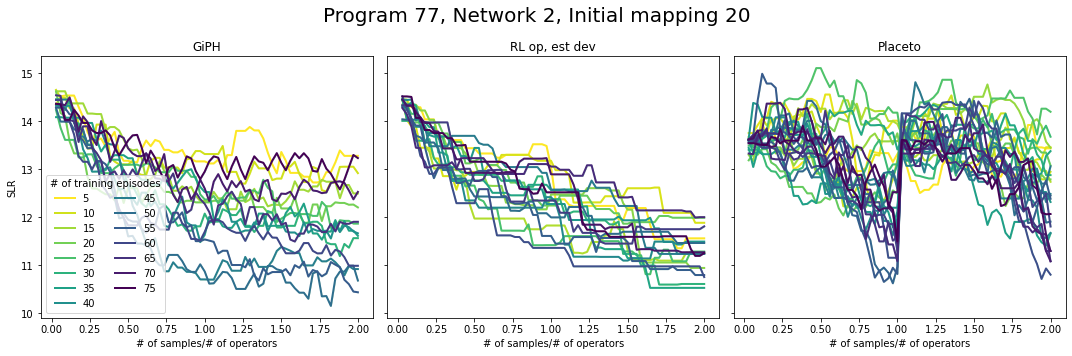

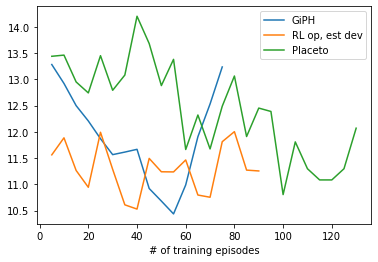

P112, N8, S20


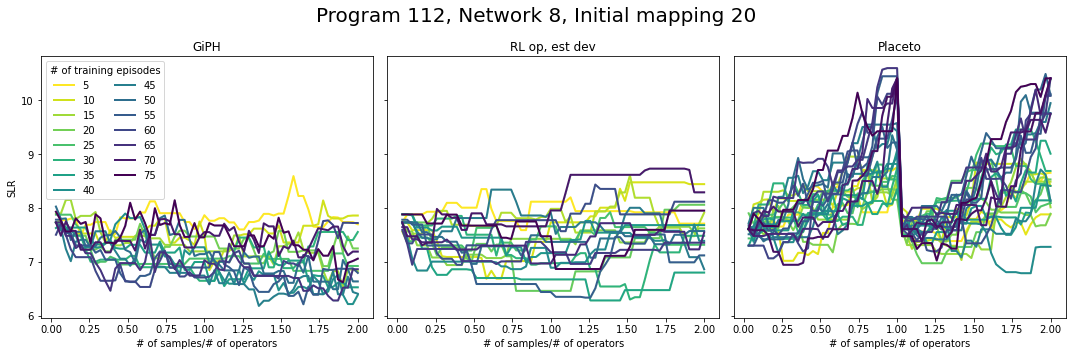

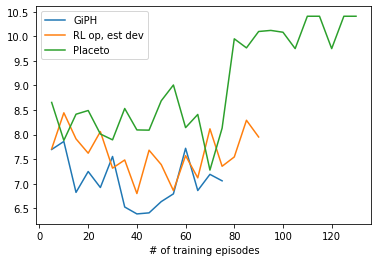

P56, N1, S20


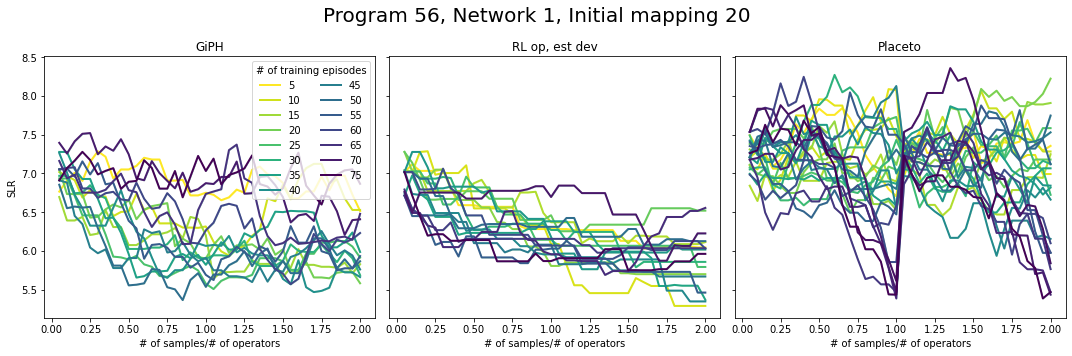

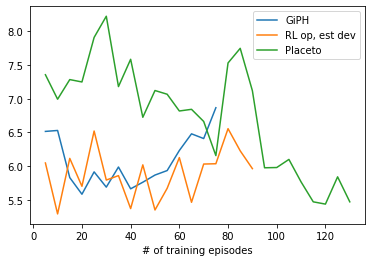

P5, N1, S20


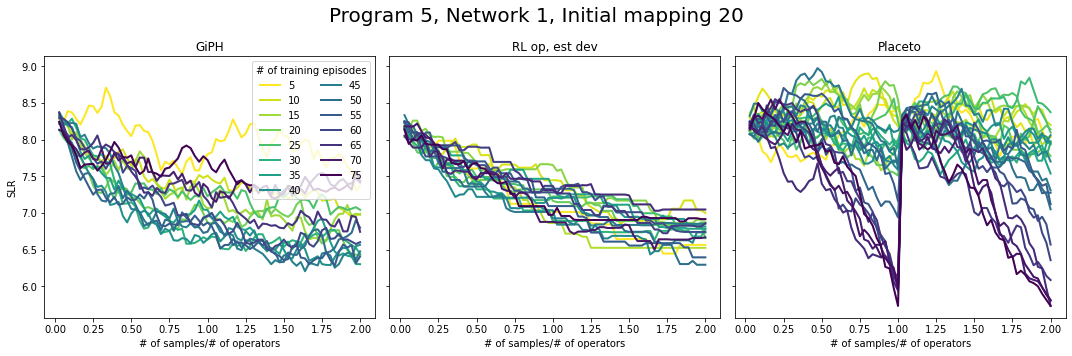

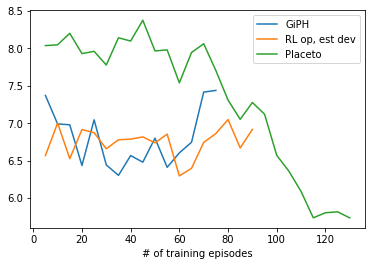

P36, N6, S20


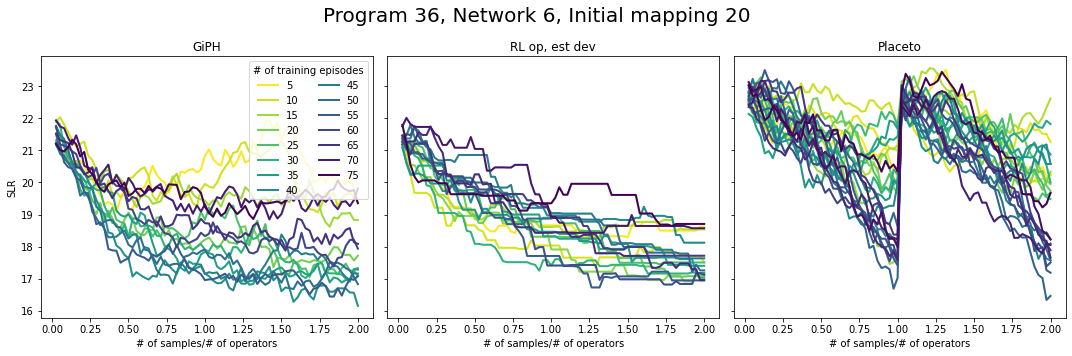

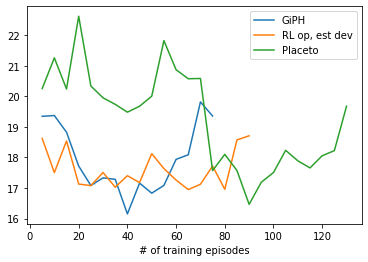

P42, N4, S20


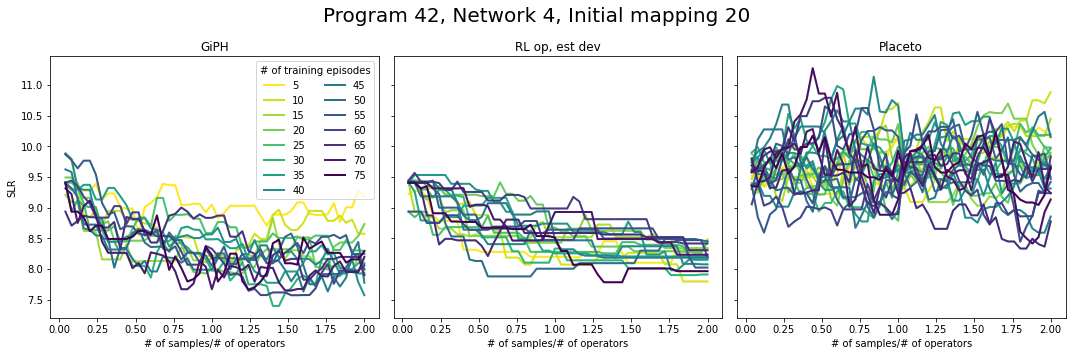

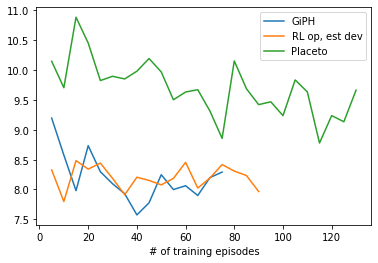

P50, N9, S20


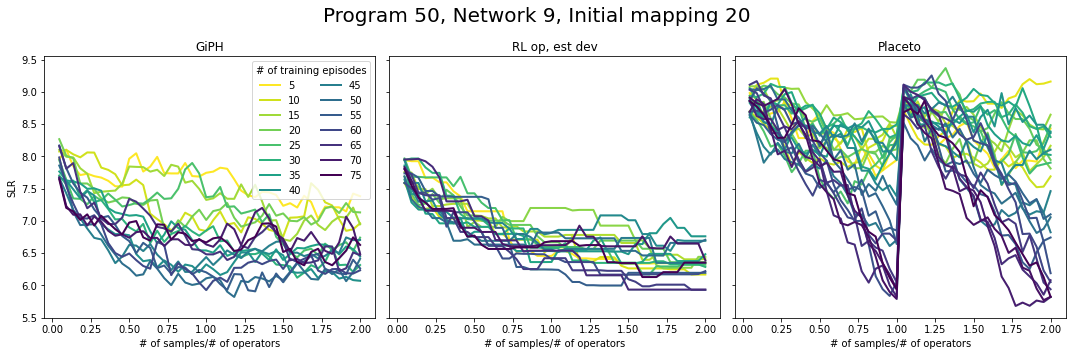

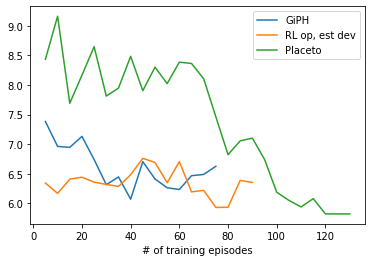

P2, N1, S20


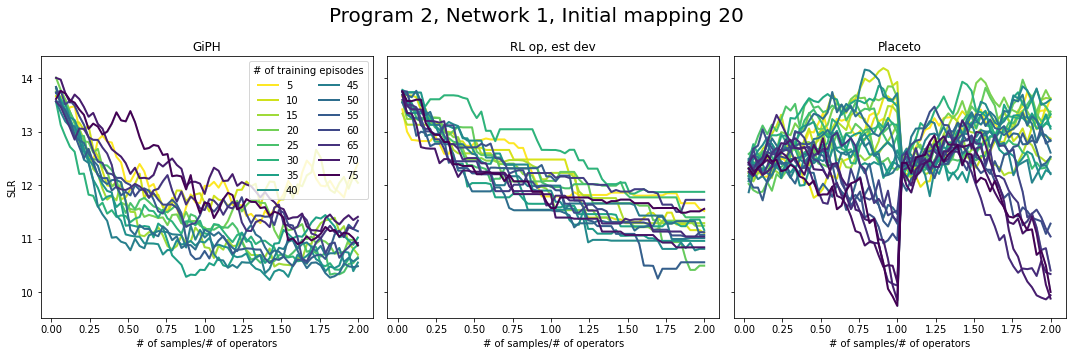

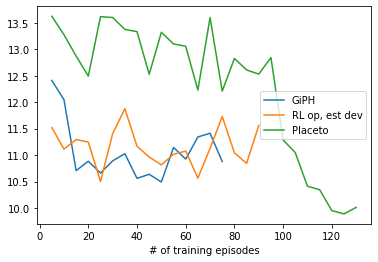

P72, N6, S20


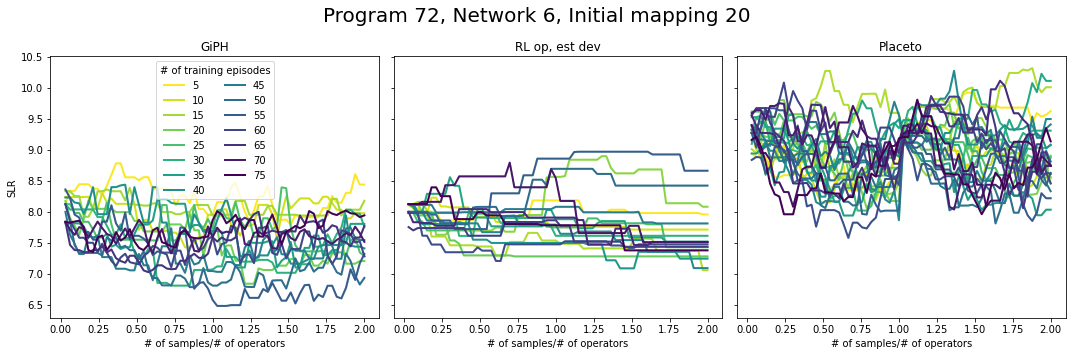

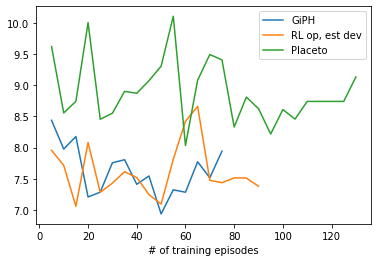

P101, N2, S20


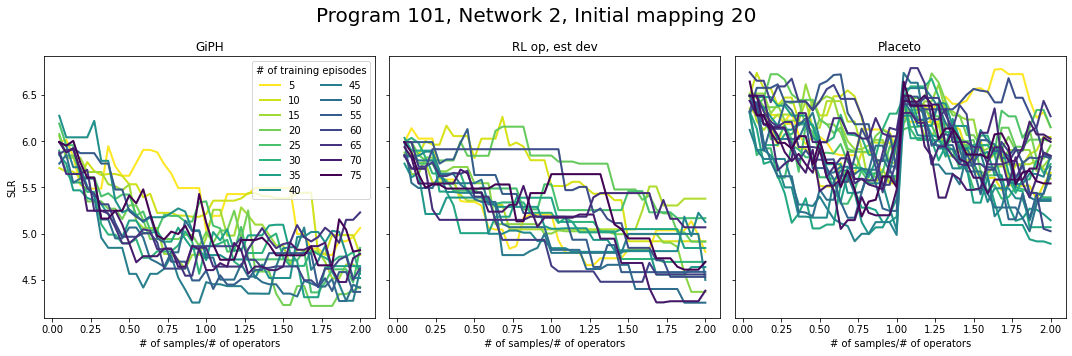

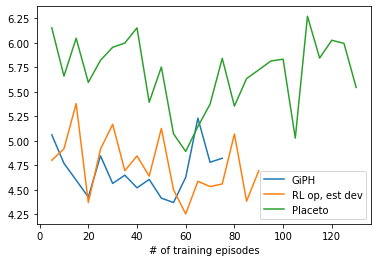

P34, N5, S20


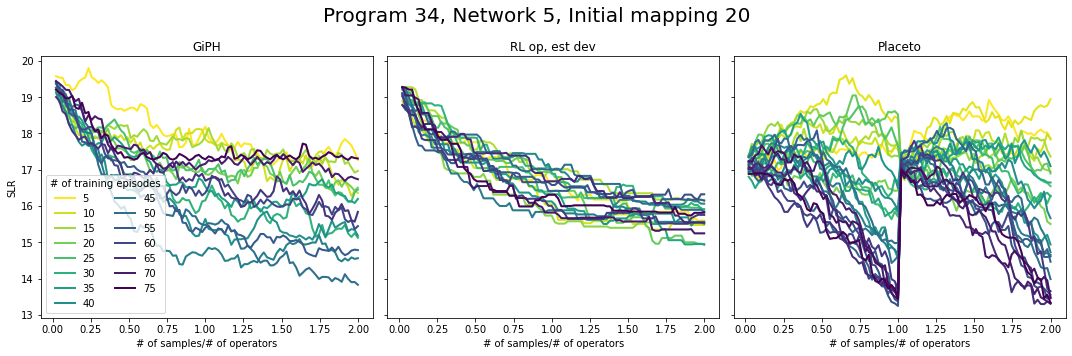

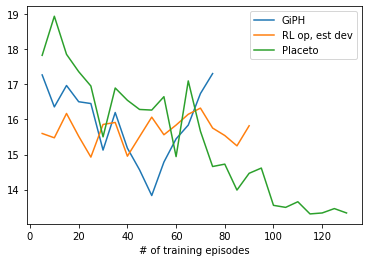

P117, N4, S20


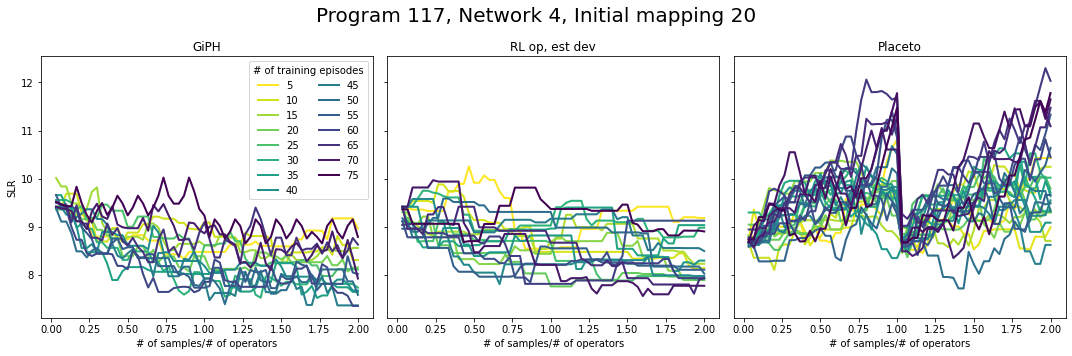

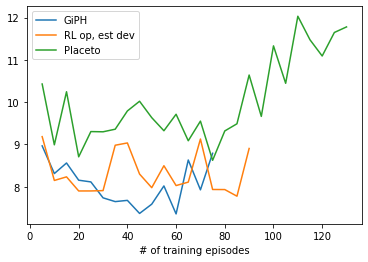

P61, N6, S20


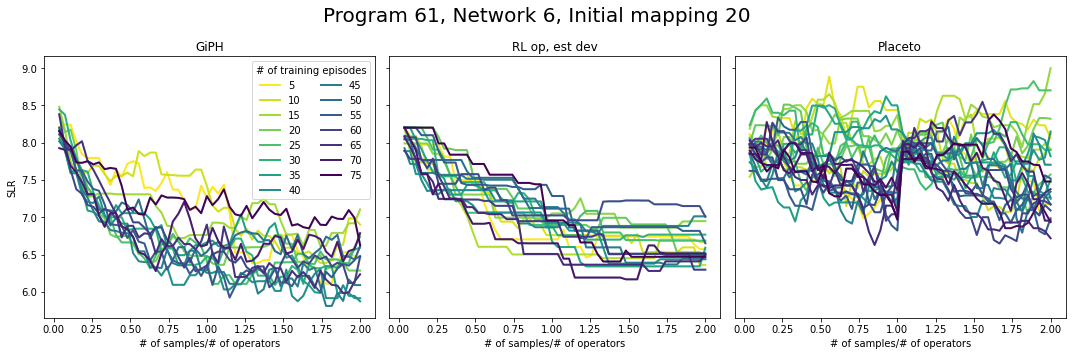

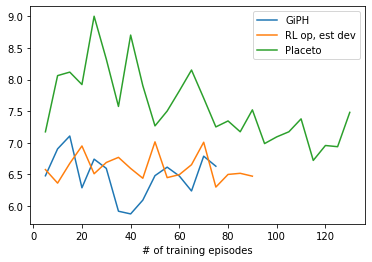

P42, N5, S20


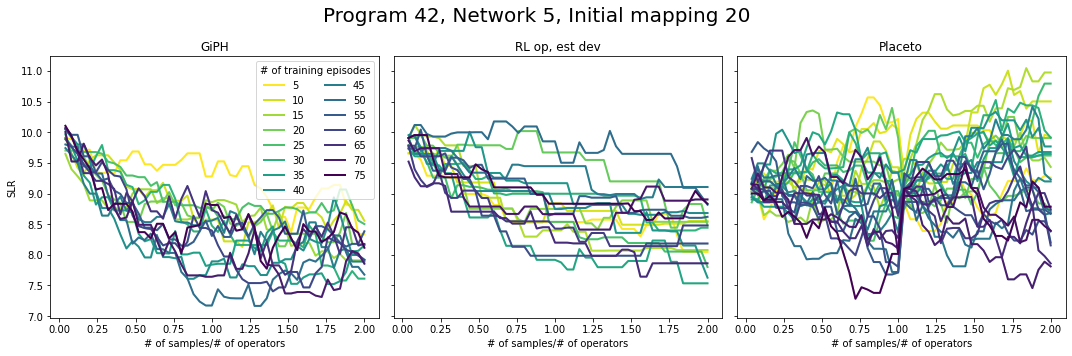

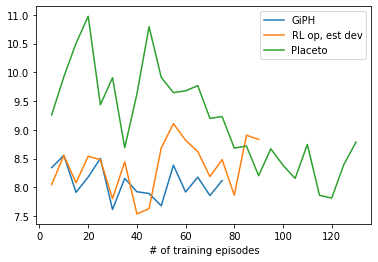

P75, N3, S20


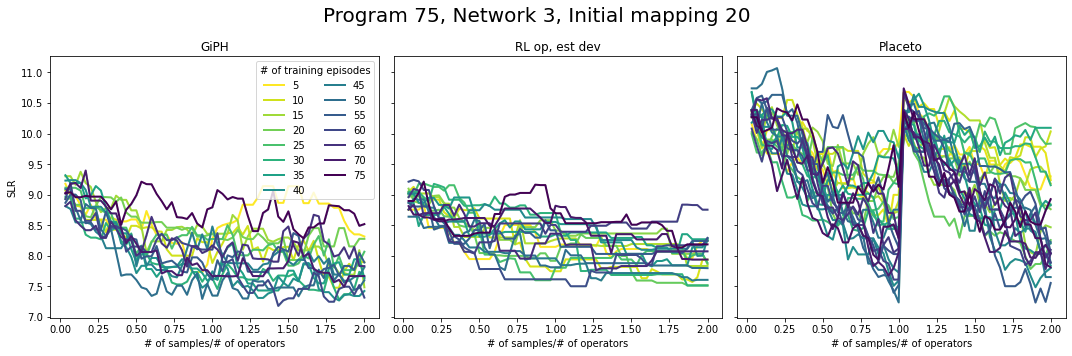

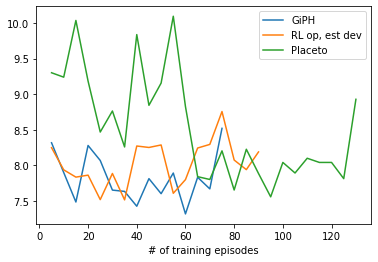

P61, N3, S20


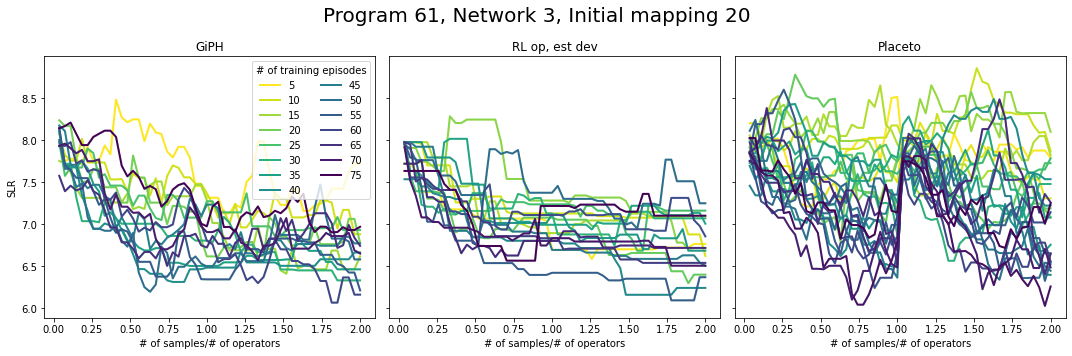

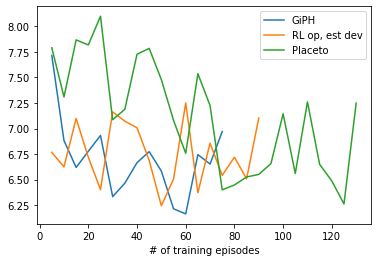

P87, N7, S20


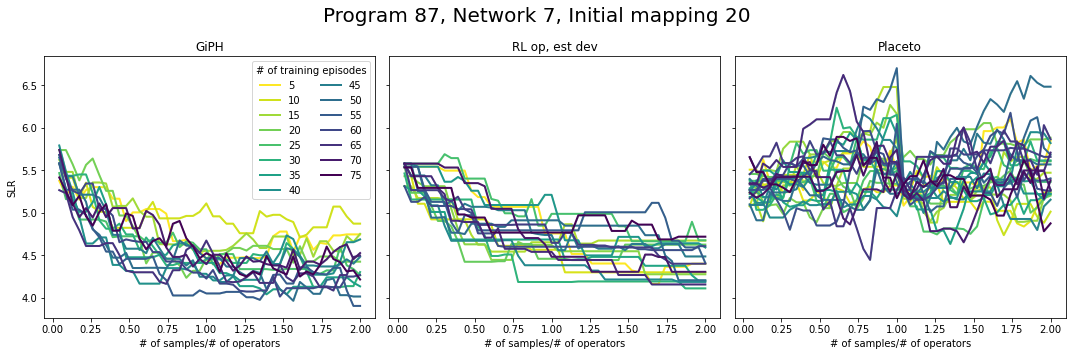

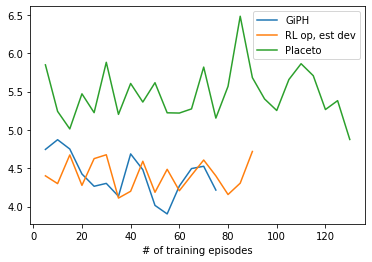

P16, N9, S20


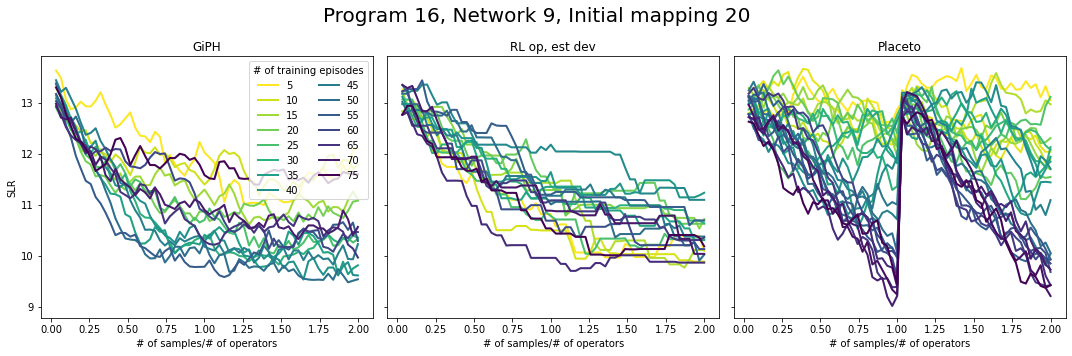

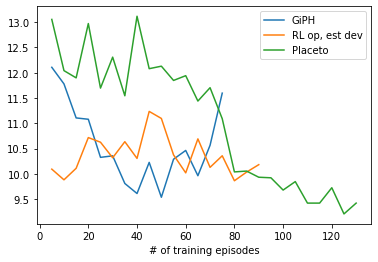

P7, N3, S20


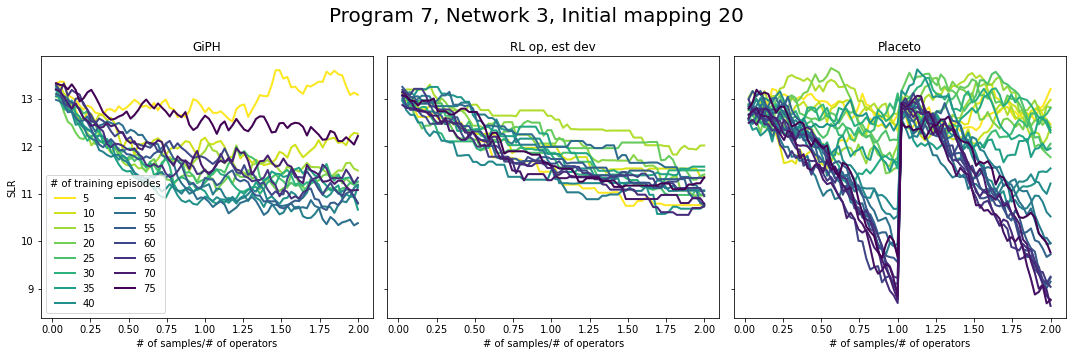

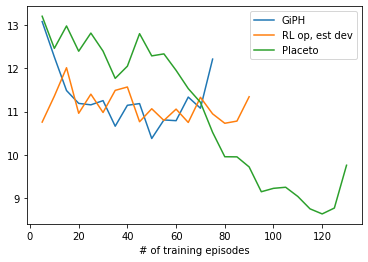

P28, N2, S20


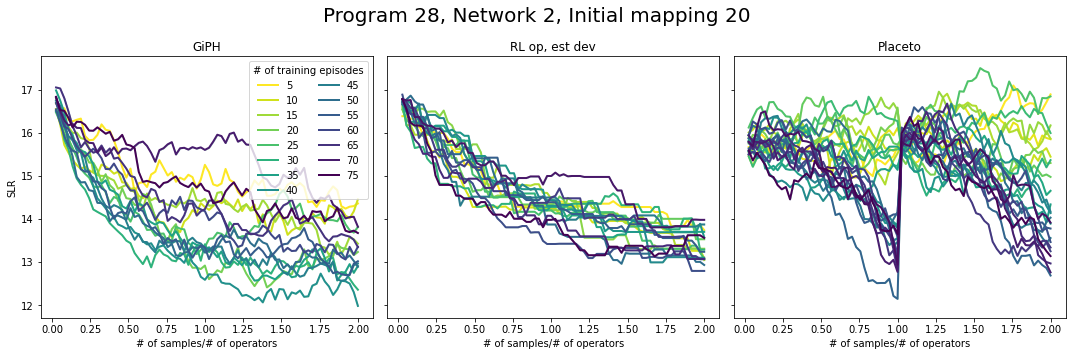

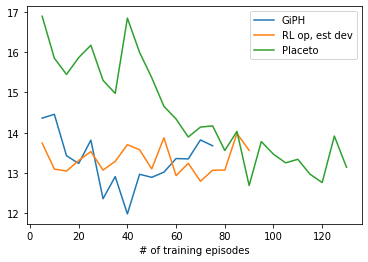

In [202]:
def plot_eval_cases_normalized(eval_datas, p_id, n_id, init_map, programs, networks, norms, names, plot_best=True):
    
    for test_program, test_network, init_seed, norm in zip (p_id, n_id, init_map, norms):
        print(f'P{test_program}, N{test_network}, S{init_seed}')
        output_results = []
        fig, ax = plt.subplots(1,len(names), figsize=(5 * len(names),5), sharey=True, sharex=True)
        for eval_data, name, k in zip(eval_datas, names, range(len(names))):
            name = name
            
            e = [list(filter(lambda episode: 
                             episode['network_id'] == test_network and
                             episode['program_id'] == test_program and
                             episode['init_seed'] == init_seed, record)) for record in eval_data]
            if plot_best:
                latency = [[[min(a['latency_trace'][:i+1]) for i in range(len(a['latency_trace']))] for a in r] for r in e]
            else:
                latency = [[a['latency_trace'] for a in r] for r in e]
            color_idx = np.linspace(0, 1, len(latency))
            num_training_episode = 5 * len(eval_data)
            legend = np.linspace(5, num_training_episode, len(latency)).astype(int)
            
            x = (np.array(range(len(latency[0][0])))+1)/programs[test_program].n_operators

            for i, label, trace in zip(color_idx, legend, latency):
                lat_train = np.array(trace)/norm
                average = np.average(lat_train, axis=0)
                var = np.std(lat_train, axis=0)
                ax[k].plot(x, average, linewidth=2, color=plt.cm.viridis_r(i), label=label)
                ax[k].fill_between(x, average + var, average - var, alpha=.25, color=plt.cm.summer_r(i))

            ax[k].set_xlabel('# of samples/# of operators')
            ax[k].set_title(name)
            
            if plot_best:
                latency = [np.array([min(a['latency_trace']) for a in r]) for r in e]
            else:
                latency = [np.array([a['latency_trace'][-1] for a in r]) for r in e]
            output_results.append(latency)
            
        leg = ax[0].legend(ncol=2)
        leg.set_title('# of training episodes')
        ax[0].set_ylabel('SLR')
        fig.suptitle(f'Program {test_program}, Network {test_network}, Initial mapping {init_seed}', fontsize=20)
        fig.tight_layout()
        plt.show()

        fig, ax = plt.subplots()
        
        for o, name in zip(output_results, names):
            ax.plot((np.arange(0, len(o))+1)*5, [np.mean(a)/norm for a in o], label = name)

        ax.set_xlabel('# of training episodes')
        ax.legend()
        plt.show()

# plot_eval_cases_normalized(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, ['devopRL', 'Placeto', 'opRL'], False)
plot_eval_cases_normalized(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, names, False)



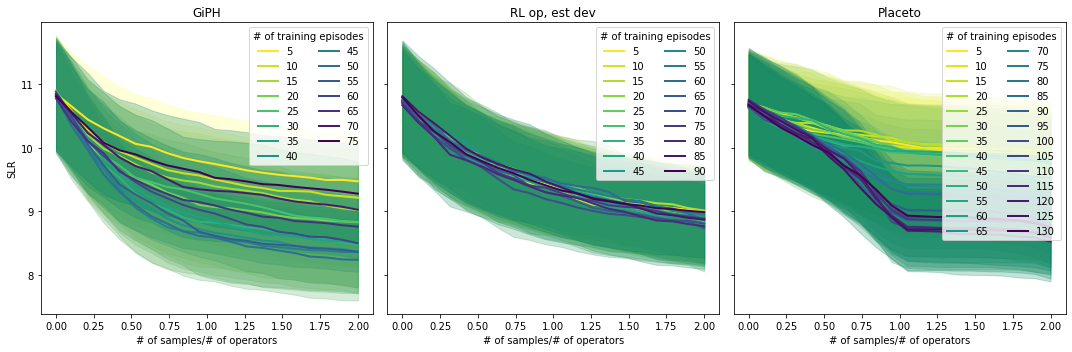

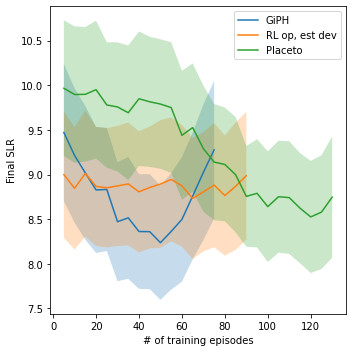

In [204]:
def plot_eval_performance_across_training_episodes(eval_datas, p_id, n_id, init_map, programs, networks, norms, names, plot_best=True):
    
    fig, ax = plt.subplots(1,len(names), figsize=(5 * len(names),5), sharey=True, sharex=True)
    ax[0].set_ylabel('SLR')
    
    fig2, ax2 = plt.subplots(1,1, figsize=(5,5))
    ax2.set_ylabel('SLR')

    num_x = 20
    x = np.linspace(0, 2, num_x)
    
    for eval_data, name, k in zip(eval_datas, names, range(len(names))):
        num_training_episode = 5 * len(eval_data)
        color_idx = np.linspace(0, 1, len(eval_data))
        legend = np.linspace(5, num_training_episode, len(eval_data)).astype(int)
        
        results = [[] for _ in range(len(eval_data))]
        num_ops = []
        slr = []
        for test_program, test_network, init_seed, norm in zip (p_id, n_id, init_map, norms):
            e = [list(filter(lambda episode: 
                             episode['network_id'] == test_network and
                             episode['program_id'] == test_program and
                             episode['init_seed'] == init_seed, record)) for record in eval_data]
            if plot_best:
                latency = [[[min(a['latency_trace'][:i+1]) for i in range(len(a['latency_trace']))] for a in r] for r in e]
            else:
                latency = [[a['latency_trace'] for a in r] for r in e]

            idx = np.linspace(1, 2 * programs[test_program].n_operators, num_x).astype(int) - 1

            for trace, i in zip(latency, range(len(latency))):
                lat_train = np.array(trace)/norm
                results[i].append(lat_train[:, idx])
            
            num_ops.append(programs[test_program].n_operators)
            slr.append([min(a)/norm for a in latency[-1]])
        comb = [np.concatenate(a, axis=0) for a in results]
        for i, label, srl in zip(color_idx, legend, comb):
            average = np.average(srl, axis=0)
            var = np.std(srl, axis=0)/5
            ax[k].plot(x, average, linewidth=2, color=plt.cm.viridis_r(i), label=label)
            ax[k].fill_between(x, average + var, average - var, alpha=.25, color=plt.cm.summer_r(i))
        leg = ax[k].legend(ncol=2)
        ax[k].set_xlabel('# of samples/# of operators')
        ax[k].set_title(name)
        leg.set_title('# of training episodes')
        
        
        output_results = np.array([a[:, -1] for a in comb])
        average = np.average(output_results, axis=1)
        std = np.std(output_results, axis=1)/5
        ax2.plot((np.arange(0, len(average))+1)*5, average, label = name)
        ax2.fill_between((np.arange(0, len(average))+1)*5, average+std, average-std, alpha=.25)

    

    ax2.legend()
    ax2.set_xlabel('# of training episodes')
    ax2.set_ylabel('Final SLR')
    
    fig.tight_layout()
    fig2.tight_layout()
    plt.show()


plot_eval_performance_across_training_episodes(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, names, True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


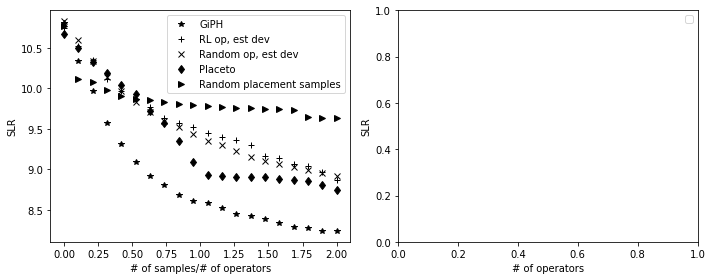

In [206]:
def plot_performance_samples(eval_datas, p_id, n_id, init_map, programs, networks, norms, names, plot_best=True, policy_idx=None, noise=0):   
    
    fig2, ax2 = plt.subplots(1,2, figsize=(10,4))
    ax2[0].set_ylabel('SLR')

    num_x = 20
    x = np.linspace(0, 2, num_x)
    
    # random baseline
    results = []
    num_ops = []
    slr = []
    for program_id, network_id, norm in zip(p_id, n_id, norms):
        prg = programs[program_id]
        net = networks[network_id]

        constraints = get_placement_constraints(prg, net)
        idx = np.linspace(1, 2 * prg.n_operators, num_x).astype(int) - 1

        sampled_latencies = []
        for i in range(1):
            _, _, random_latency = random_placement(prg, net, constraints, 2 * prg.n_operators, noise)
            sampled_latencies.append(random_latency)
        
        if plot_best:
            sampled_latencies = [[min(a[:i+1]) for i in range(len(a))] for a in sampled_latencies]
        
        sampled_latencies = np.array(sampled_latencies)/norm
        results.extend(sampled_latencies[:, idx])
        num_ops.append(prg.n_operators)
        slr.append([min(a) for a in sampled_latencies])
    
    results = np.array(results)
    average = np.mean(results, axis=0)
    var = np.std(results, axis=0)/5
    ax2[0].plot(x, average, '>k', label='Random placement samples', ms = 6)
#     ax2[0].fill_between(x, average + var, average - var, alpha=.25)
#     print("Random sampling finishes")
#     xs = [num_ops[i]  for i in range(len(slr)) for _ in range(len(slr[i])) ]
#     ys = [item.item() for a in slr for item in a]
#     ax2[1].scatter(xs, ys, label='Random samples')
    
    # random op selection, est dev selection
    results = []
    num_ops = []
    slr = []
    for program_id, network_id, init_seed, norm in zip(p_id, n_id,init_map, norms):
        prg = programs[program_id]
        net = networks[network_id]
        
        np.random.seed(init_seed)

        constraints = get_placement_constraints(prg, net)
        init_mapping = [np.random.choice(constraints[i]) for i in range(prg.n_operators)]
        idx = np.linspace(1, 2 * prg.n_operators, num_x).astype(int) - 1

        sampled_latencies = []
        for i in range(3):
            _, _, random_latency = random_op_est_dev(prg, net, init_mapping, 2 * prg.n_operators, noise)
            sampled_latencies.append(random_latency)
        
        if plot_best:
            sampled_latencies = [[min(a[:i+1]) for i in range(len(a))] for a in sampled_latencies]
        
        sampled_latencies = np.array(sampled_latencies)/norm
        results.extend(sampled_latencies[:, idx])
        num_ops.append(prg.n_operators)
        slr.append([min(a) for a in sampled_latencies])
    
    results = np.array(results)
    average = np.mean(results, axis=0)
    var = np.std(results, axis=0)/5
    ax2[0].plot(x, average, 'xk', label='Random op, est dev', ms = 6)
#     ax2[0].fill_between(x, average + var, average - var, alpha=.25)
    
    
    
    if not policy_idx:
        policy_idx = [-1 for _ in range(len(names))]
    for eval_data, name, idx, k in zip(eval_datas, names, policy_idx, range(len(names))):
        num_training_episode = 5 * len(eval_data)
        color_idx = np.linspace(0, 1, len(eval_data))
        legend = np.linspace(5, num_training_episode, len(eval_data)).astype(int)
        
        eval_data = eval_data[idx]
        results = []
        num_ops = []
        slr = []
        for test_program, test_network, init_seed, norm in zip (p_id, n_id, init_map, norms):
            e = list(filter(lambda episode: 
                             episode['network_id'] == test_network and
                             episode['program_id'] == test_program and
                             episode['init_seed'] == init_seed, eval_data))
            if plot_best:
                latency = [[min(a['latency_trace'][:i+1]) for i in range(len(a['latency_trace']))] for a in e] 
            else:
                latency = [a['latency_trace'] for a in e]

            idx = np.linspace(1, 2 * programs[test_program].n_operators, num_x).astype(int) - 1
            
            lat_train = np.array(latency)/norm
            results.extend(lat_train[:, idx])
            
            num_ops.append(programs[test_program].n_operators)
            slr.append([min(a)/norm for a in latency])


        results = np.array(results)
        average = np.mean(results, axis=0)
        var = np.std(results, axis=0)/5
        ax2[0].plot(x, average, markers[name]+'k', label=name, ms = 6)
#         ax2[0].fill_between(x, average + var, average - var, alpha=.25)
        
        xs = [num_ops[i]  for i in range(len(slr)) for _ in range(len(slr[i])) ]
        ys = [item.item() for a in slr for item in a]
#         ax2[1].scatter(xs, ys, label=name)

    
    ax2[0].set_xlabel('# of samples/# of operators')
    ax2[0].set_ylabel('SLR')
#     ax2[0].set_ylim([6,9])
    
    ax2[0].legend()
    handles, labels = ax2[0].get_legend_handles_labels()
    order = [2,3,1,4,0]
    ax2[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1)
    ax2[1].legend()
    ax2[1].set_xlabel('# of operators')
    ax2[1].set_ylabel('SLR')
    fig2.tight_layout()
    plt.show()

# plot_performance_samples(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, ['devopRL', 'Placeto', 'opRL'], True)   
plot_performance_samples(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, names, True, [9, 11, -1])   



In [132]:
def get_test_cases(logdir):    
    _, cdir = os.walk(logdir)
    logdir = cdir[0]
    networks, programs = pickle.load(open(join(logdir, 'test_data.pkl'), 'rb'))
    run_data =  json.load(open(join(logdir, 'run_data.txt'), 'r'))
    n_id, p_id, init_map = [s[0] for s in run_data['test_sequence']], [s[1] for s in run_data['test_sequence']], [s[2] for s in run_data['test_sequence']]
    
    norm_serial_min = []
    norm_serial_avg = []
    norm_cp = []
    
    for program_id, network_id in zip(p_id, n_id):
        
        prg = programs[program_id]
        net = networks[network_id]

        constraints = get_placement_constraints(prg, net)

        comp_min = []
        comm_min = []

        comp_a = []
        comm_a = []

        for n in prg.P.nodes():
            comp_t = [computation_latency(prg, net, n, dev) for dev in constraints[n]]
            comp_min.append(min(comp_t))
            comp_a.append(np.mean(comp_t))
            for e in prg.P.out_edges(n):
                prg.P.edges[e]['weight'] = min(comp_t)

        for e in prg.P.edges():
            d1 = constraints[e[0]]
            d2 = constraints[e[1]]
            comm_t = [communication_latency(prg, net, e[0],e[1], dev1, dev2) for dev1 in d1 for dev2 in d2]
            comm_min.append(min(comm_t))
            comm_a.append(np.mean(comm_t))
        norm_serial_min.append(np.sum(comp_min) + np.sum(comm_min))
        norm_serial_avg.append(np.sum(comp_a) + np.sum(comm_a))
        norm_cp.append(nx.shortest_path_length(prg.P, source=0, target=prg.P.number_of_nodes()-1, weight='weight').item() + comp_min[-1])
    norm_cp = [a.item() for a in norm_cp]
    return p_id, n_id, init_map, programs, networks, norm_serial_min, norm_serial_avg, norm_cp



logdir='runs/single_network/2022-05-10_18-45-59_opdevRL'
logdir_p = 'runs/single_network/2022-05-10_18-46-25_placeto'
logdir_op = 'runs/single_network/2022-05-10_18-46-12_opRL'
p_id, n_id, init_map, programs, networks, norm_serial_min, norm_serial_avg, norm_cp = get_test_cases(logdir)
p_id1, n_id1, init_map1, programs1, networks1, norm_serial_min1, norm_serial_avg1, norm_cp1 = get_test_cases(logdir_p)
p_id2, n_id2, init_map2, programs2, networks2, norm_serial_min2, norm_serial_avg2, norm_cp2 = get_test_cases(logdir_op)

print(np.sum(np.absolute(np.array(norm_serial_min1) - np.array(norm_serial_min))))



18706.717011704313


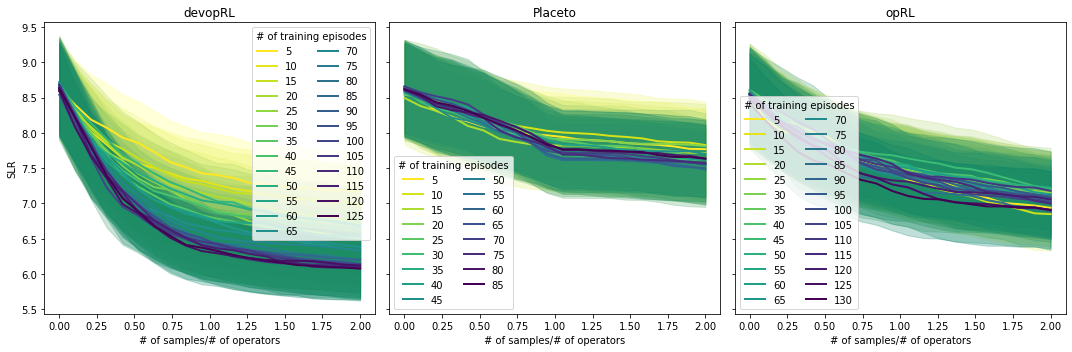

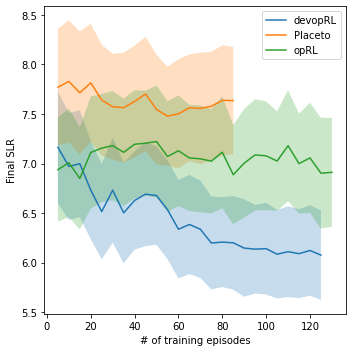

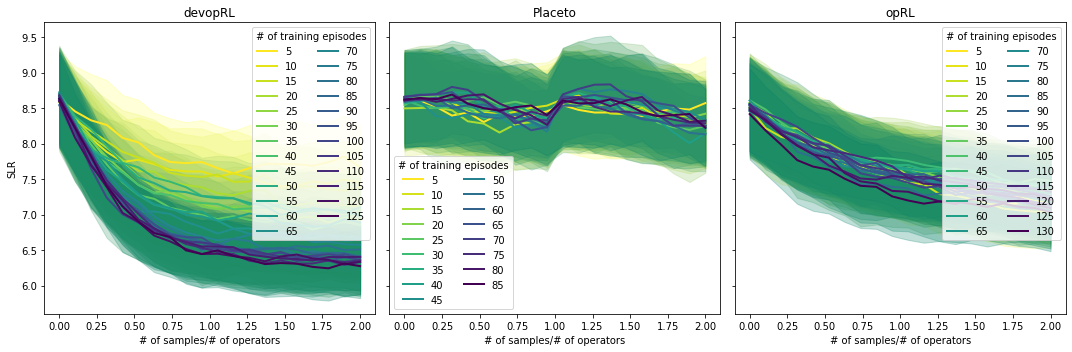

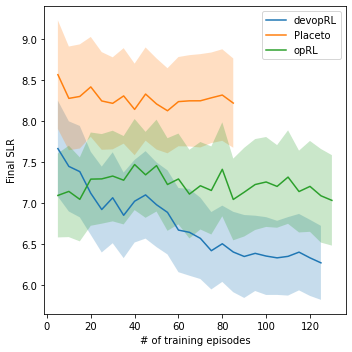

In [94]:
logdir='runs/similar_program/2022-05-10_18-45-59_opdevRL'
logdir_p = 'runs/similar_program/2022-05-10_18-46-25_placeto'
logdir_op = 'runs/similar_program/2022-05-10_18-46-12_opRL'
p_id, n_id, init_map, programs, networks, norm_serial_min, norm_serial_avg, norm_cp = get_eval_cases(logdir)

eval_datas = [pickle.load(open(join(ld, 'eval.pk'), 'rb')) for ld in [logdir,logdir_p, logdir_op]]

# plot_eval_cases_normalized(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, ['devopRL', 'Placeto', 'opRL'], True)
# plot_eval_cases_normalized(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, ['devopRL', 'Placeto', 'opRL'], False)

plot_eval_performance_across_training_episodes(eval_datas, p_id, n_id, init_map, programs, networks, norm_cp, ['devopRL', 'Placeto', 'opRL'], True)


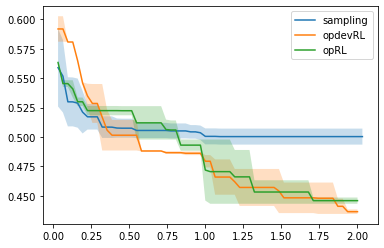

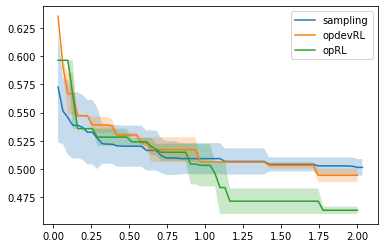

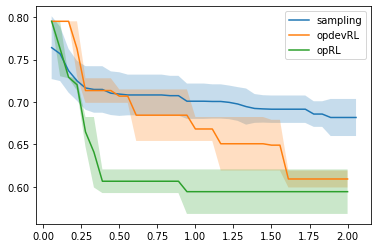

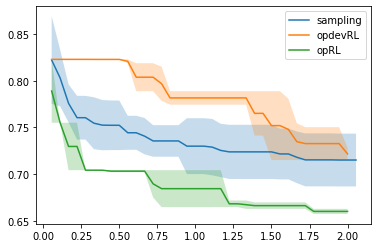

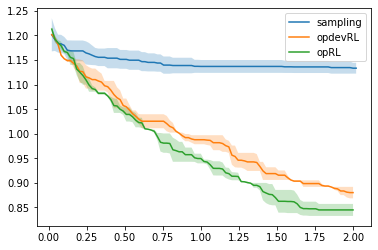

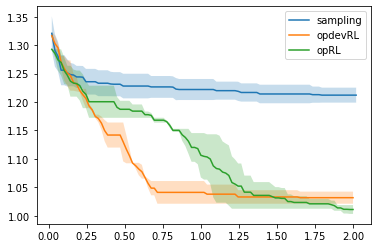

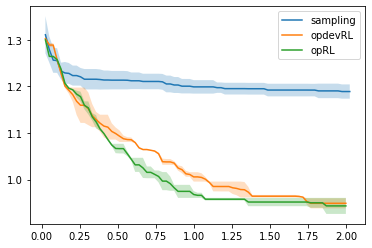

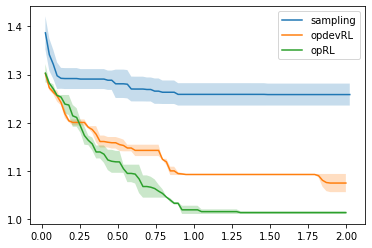

In [77]:
logdir='runs/p1/2022-05-04_10-39-13_more_train_data_opRL'

for min_latencies_sample, min_latencies_opdev, min_latencies_op, program_id, network_id, norm in zip (best_sample_latencies, test_opdev, test_op, p_id, n_id, norm_serial_min):
    prg = programs[program_id]
    net = networks[network_id]
    
    constraints = get_placement_constraints(prg, net)
    
    normalized = np.array([np.array(l)/norm for l in min_latencies_sample])
    mean = np.mean(normalized, axis=0)
    std = np.std(normalized, axis=0)
    x = (np.array(range(len(mean)))+1)/programs[program_id].n_operators
    plt.plot(x, mean, label='sampling' )
    plt.fill_between(x, mean + std, mean - std, alpha=.25)
    
    normalized = np.array([np.array(l)/norm for l in min_latencies_opdev])
    mean = np.mean(normalized, axis=0)
    std = np.std(normalized, axis=0)
    x = (np.array(range(len(mean)))+1)/programs[program_id].n_operators
    plt.plot(x, mean, label='opdevRL' )
    plt.fill_between(x, mean + std, mean - std, alpha=.25)
    
    normalized = np.array([np.array(l)/norm for l in min_latencies_op])
    mean = np.mean(normalized, axis=0)
    std = np.std(normalized, axis=0)
    x = (np.array(range(len(mean)))+1)/programs[program_id].n_operators
    plt.plot(x, mean, label='opRL' )
    plt.fill_between(x, mean + std, mean - std, alpha=.25)
    
    plt.legend()
    plt.show()

{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P0, N0, S20


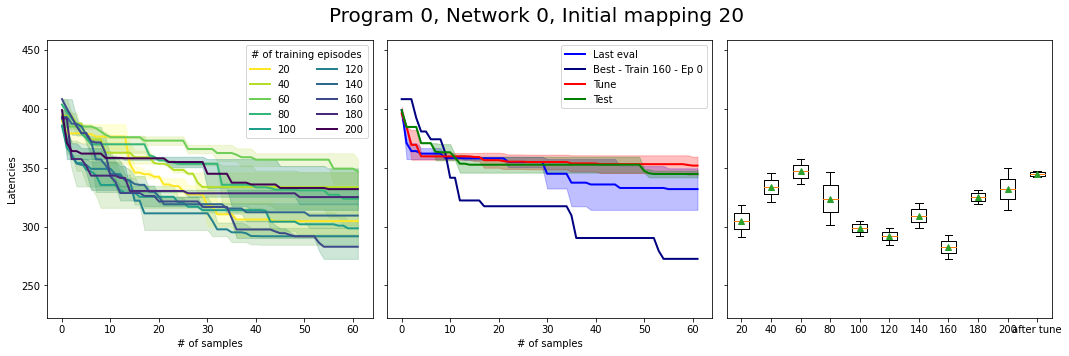

{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 21, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P0, N1, S20


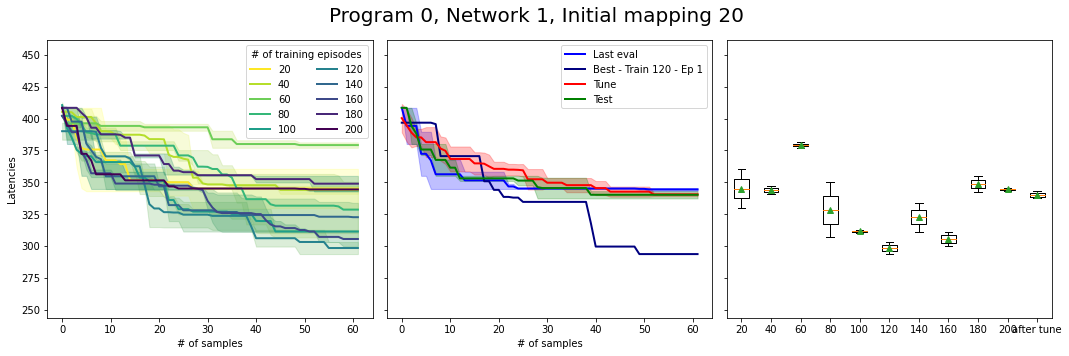

{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P1, N0, S20


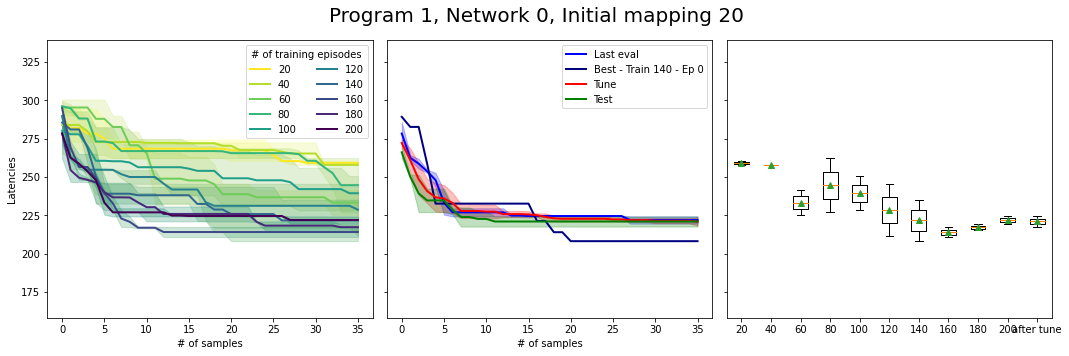

{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 21, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P1, N1, S20


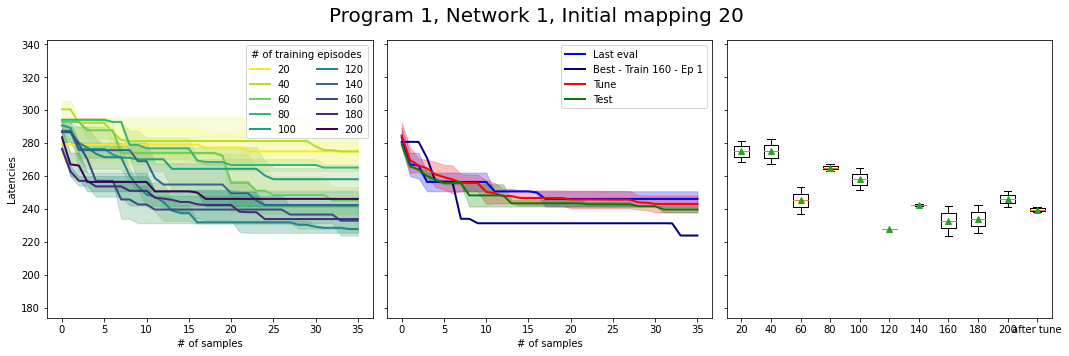

{'alpha': 0.1, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P2, N0, S20


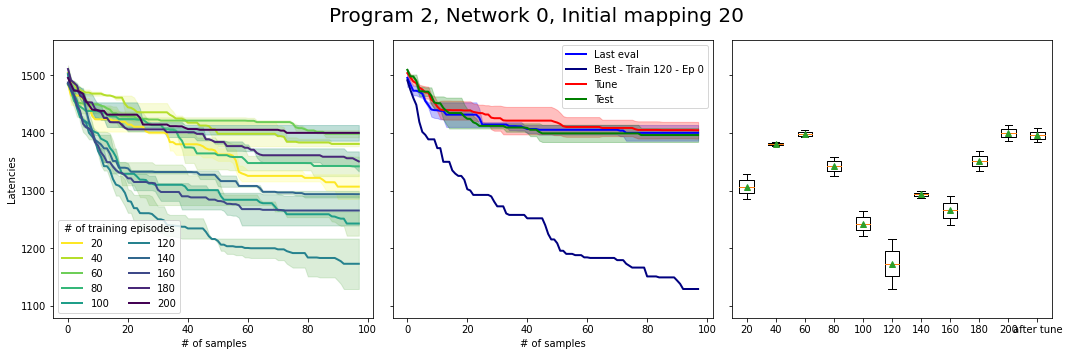

{'alpha': 0.1, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 21, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P2, N1, S20


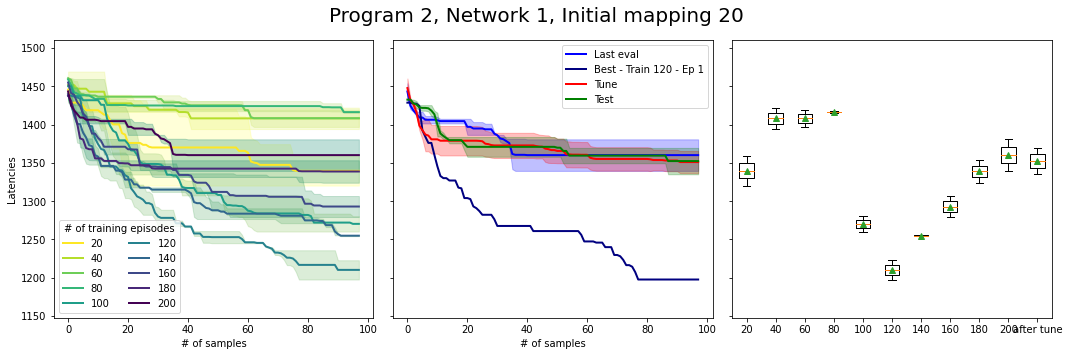

{'alpha': 0.1, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P3, N0, S20


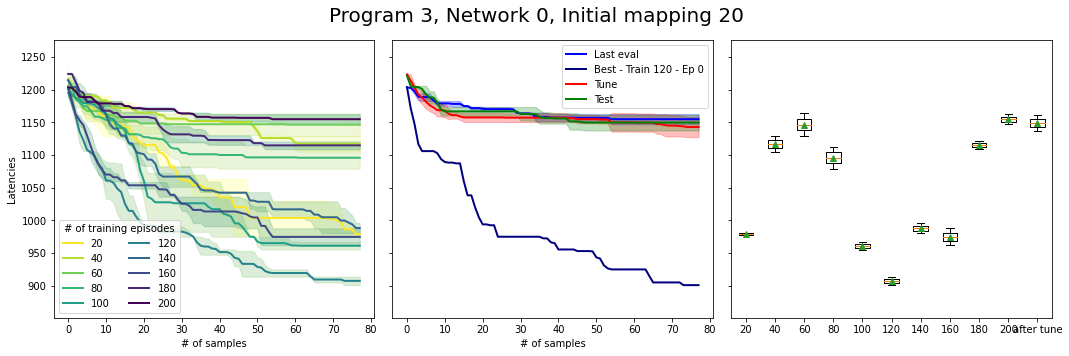

{'alpha': 0.1, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 21, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P3, N1, S20


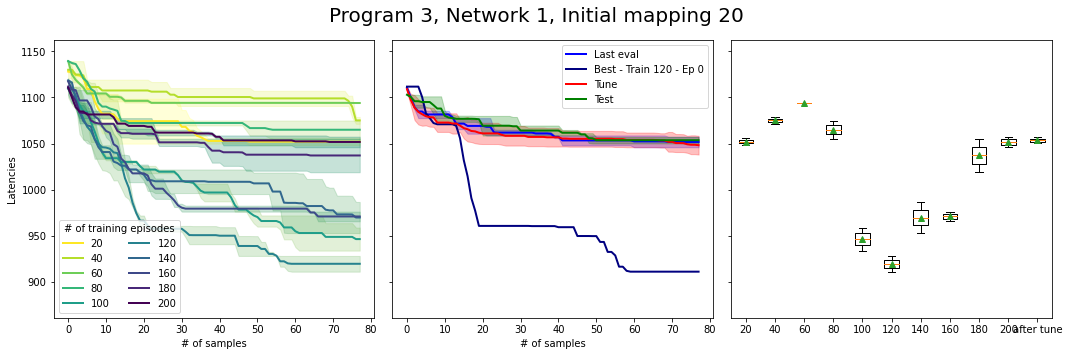

{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P0, N0, S20
{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 20, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 21, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P0, N1, S20
{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp': 0.2, 'b_comm': 0.2}
{'n_devices': 25, 'seed': 20, 'num_types': 5, 'type_prob': 0.2, 'avg_speed': 5, 'avg_bw': 100, 'avg_delay': 10, 'b_bw': 0.2, 'b_speed': 0.2}
P1, N0, S20
{'alpha': 0.5, 'v': 20, 'connect_prob': 0.2, 'seed': 21, 'num_types': 5, 'avg_compute': 100, 'avg_bytes': 100, 'b_comp

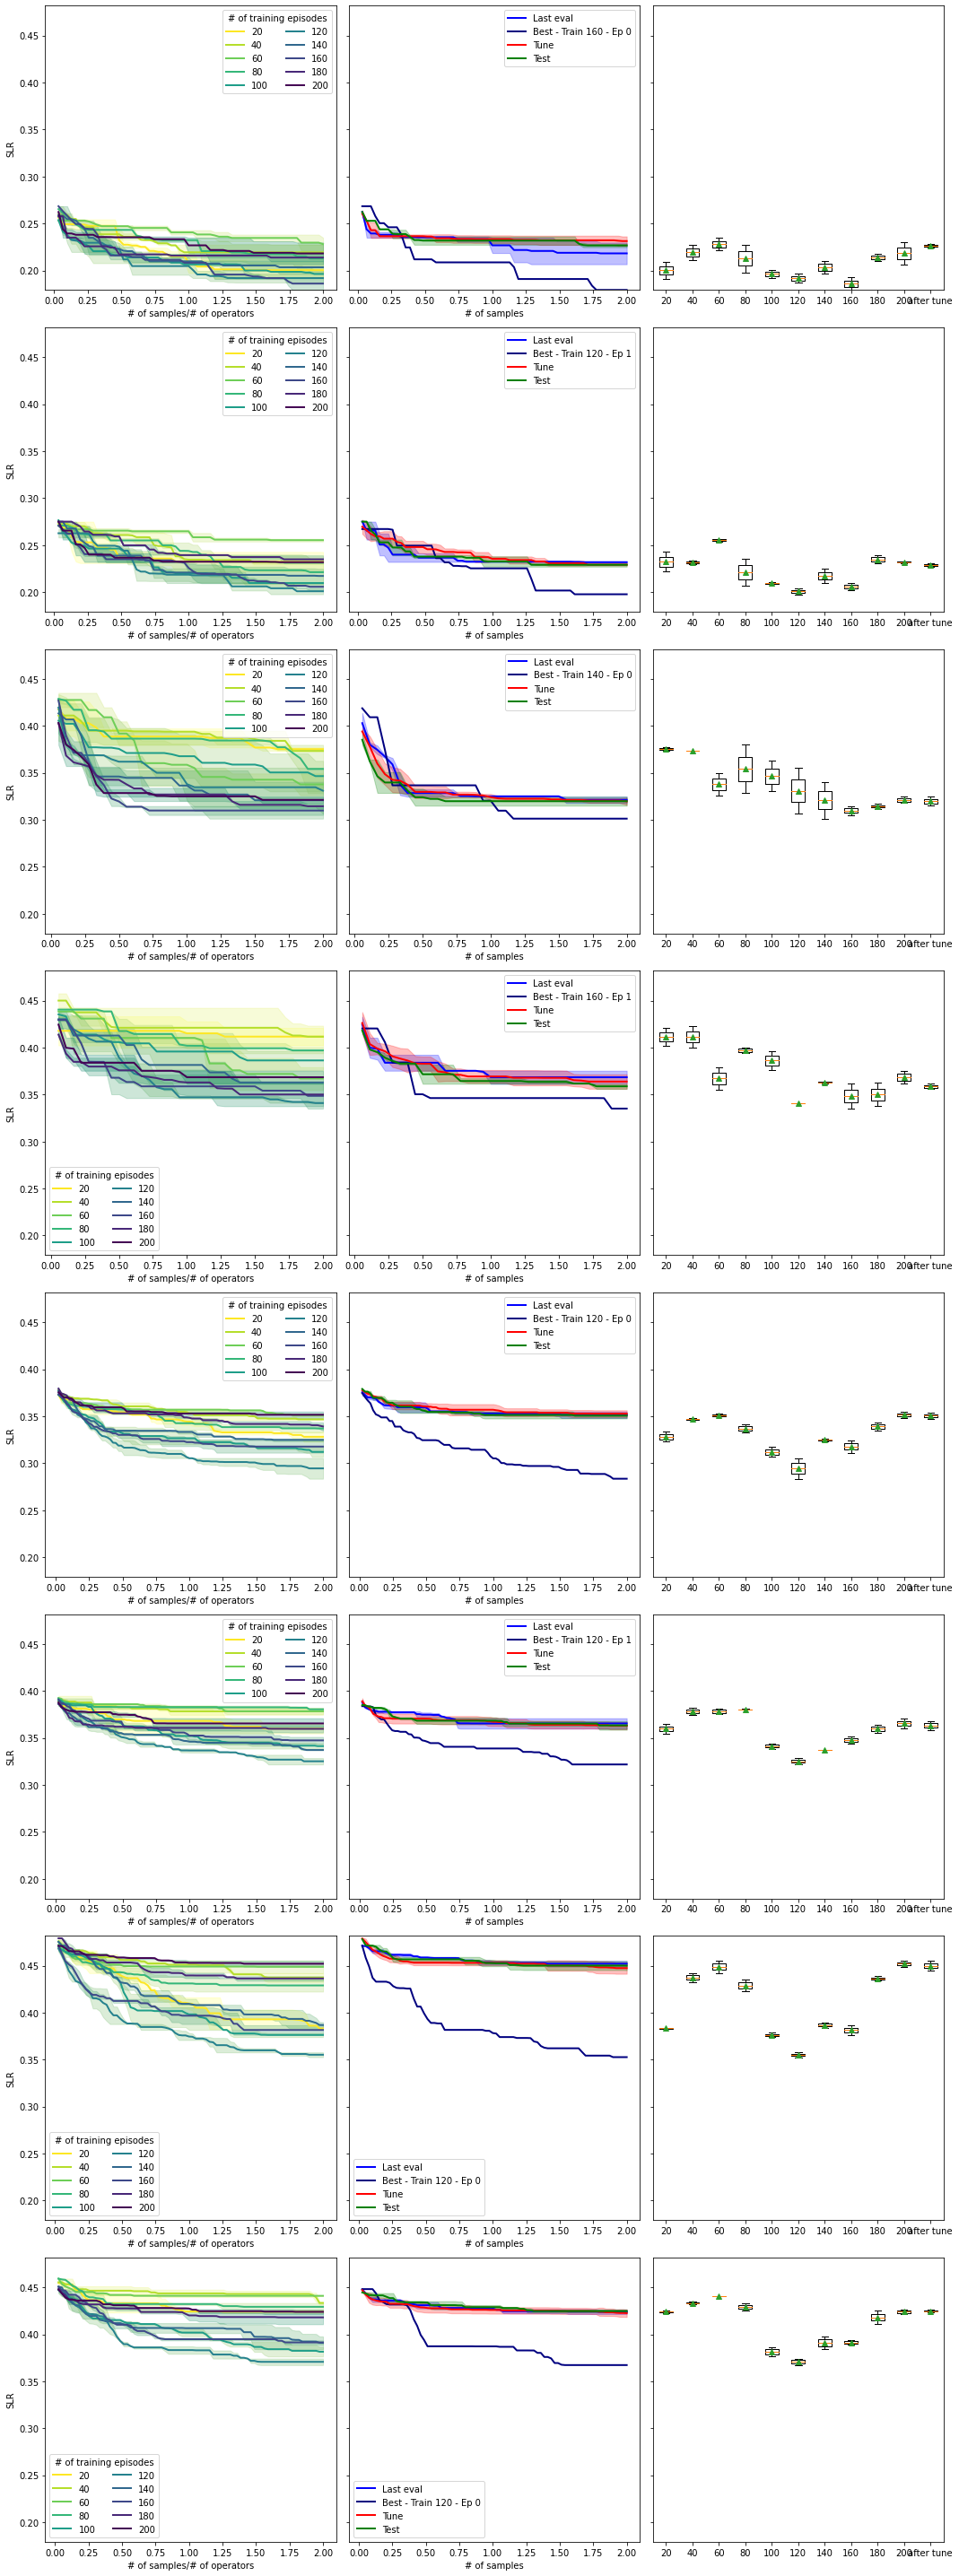

Program 0, Network 0, Init mapping 20
Program 0, Network 1, Init mapping 20
Program 1, Network 0, Init mapping 20
Program 1, Network 1, Init mapping 20
Program 2, Network 0, Init mapping 20
Program 2, Network 1, Init mapping 20
Program 3, Network 0, Init mapping 20
Program 3, Network 1, Init mapping 20


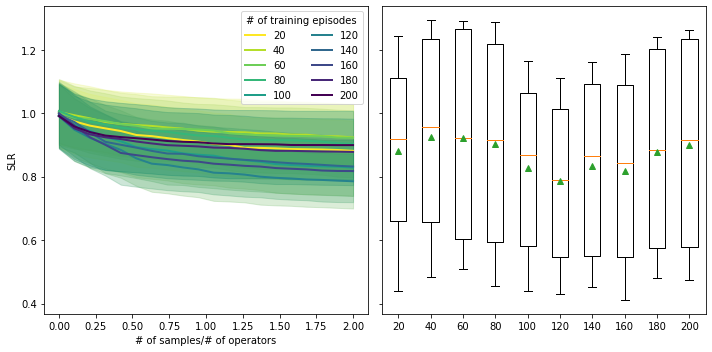

Program 0, Network 0, Init mapping 20
Program 0, Network 1, Init mapping 20
Program 1, Network 0, Init mapping 20
Program 1, Network 1, Init mapping 20
Program 2, Network 0, Init mapping 20
Program 2, Network 1, Init mapping 20
Program 3, Network 0, Init mapping 20
Program 3, Network 1, Init mapping 20


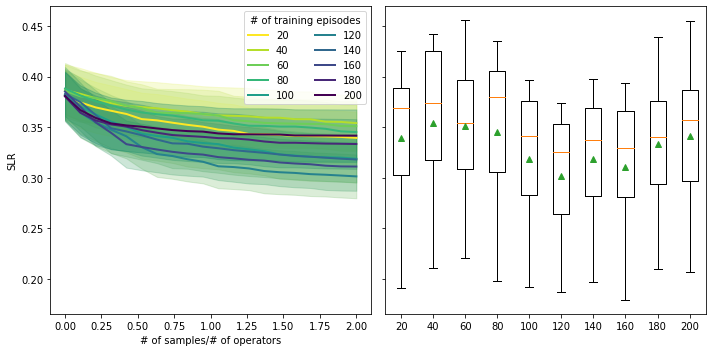

In [78]:
logdir='runs/more_networks/2022-05-06_06-15-29_opdevRL'
p_id, n_id, programs, networks, norm_serial_min, norm_serial_avg = get_test_cases(logdir)
test_opdev, turn_opdev = plot_test_cases(logdir,p_id, n_id, programs, networks)  
plot_test_cases_normalized(logdir,p_id, n_id, programs, networks, norm_serial_avg)  
plot_test_performance(logdir,p_id, n_id, programs, networks, norm_serial_min)  
plot_test_performance(logdir,p_id, n_id, programs, networks, norm_serial_avg)   

In [9]:
from experiment import run_episodes
from placement_rl.placement_env import PlacementEnv

def get_opdevRL_data(number_of_tests, p_id, n_id, programs, networks, logdir, noise):
    exp_cfg = pickle.load(open(join(logdir, 'args.pkl'), 'rb'))
    env = PlacementEnv (list(networks.values()), list(programs.values()))
    sample_latencies = []
    
    seed = 0
    
    for program_id, network_id in zip(p_id, n_id):
        prg = programs[program_id]
        net = networks[network_id]
        
        agent = PlacementAgent(PlacementEnv.get_node_feature_dim(), PlacementEnv.get_edge_feature_dim(), exp_cfg.output_dim,
                                    hidden_dim=exp_cfg.hidden_dim, lr=exp_cfg.lr, gamma=exp_cfg.gamma)
        
        agent.policy.load_state_dict(torch.load(os.path.join(logdir, 'policy.pk'), map_location=torch.device('cpu')))
        agent.embedding.load_state_dict(torch.load(os.path.join(logdir, 'embedding.pk'), map_location=torch.device('cpu')))

        constraints = get_placement_constraints(prg, net)

        results = run_episodes(env, agent,
                        [program_id] * number_of_tests,
                         [network_id] * number_of_tests,
                             [seed]* number_of_tests,
                             use_full_graph=True,
                             use_bip_connection=False,
                             explore=True,
                             samples_to_ops_ratio=2,
                             update_policy=False,
                             save_data=True,
                             save_dir=logdir,
                             save_name=f'test_explore_program_{program_id}_network_{network_id}_seed_{seed}',
                             noise=noise)

        min_latencies = [[min(episode['latency_trace'][:i+1]) for i in range(len(episode['latency_trace']))] for episode in results]
        sample_latencies.append(min_latencies)
    return sample_latencies

opdevRL_latencies = get_opdevRL_data(5, p_id, n_id, programs, networks, logdir, 0)


0th case: {'network_id': 0, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}


/Users/yihu/opt/anaconda3/envs/default/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  return warnings.warn(message, category=category, stacklevel=1)


1th case: {'network_id': 0, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
2th case: {'network_id': 0, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
3th case: {'network_id': 0, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
4th case: {'network_id': 0, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
0th case: {'network_id': 1, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
1th case: {'network_id': 1, 'program_id': 0, 'init_seed': 0, 'noise': 0, 'num_of_samples': 62, 'episodes': [], 'sampled_placement': [], 'latency_trace': []}
2th case: {'network_id': 1, 'program_id': 0, 'init_seed': 

## random samples

In [23]:
def get_best_sampling_data(number_of_tests, p_id, n_id, programs, networks, noise):
    best_sample_latencies = []
    best_sample_num_samples = []
    for program_id, network_id in zip(p_id, n_id):
        prg = programs[program_id]
        net = networks[network_id]

        constraints = get_placement_constraints(prg, net)

        sampled_latencies = []
        for i in range(number_of_tests):
            _, _, random_latency = random_placement(prg, net, constraints, 2 * prg.n_operators, noise)
            sampled_latencies.append(random_latency)

        min_latencies = [[min(a[:i+1]) for i in range(len(a))] for a in sampled_latencies]
        best_sample_latencies.append(min_latencies)
    return best_sample_latencies

best_sample_latencies = get_best_sampling_data(10, p_id, n_id, programs, networks, 0)


(10, 63)
(5, 61)


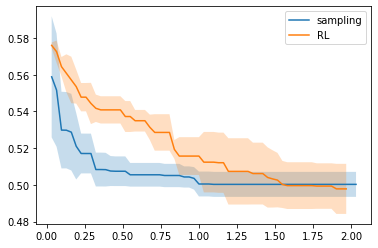

(10, 63)
(5, 61)


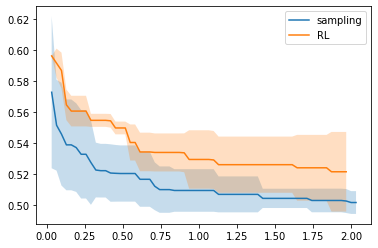

(10, 37)
(5, 35)


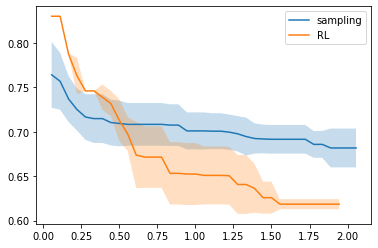

(10, 37)
(5, 35)


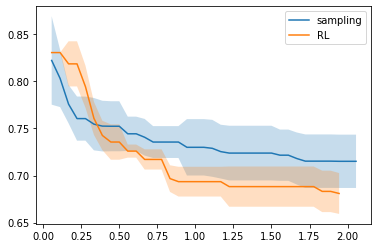

(10, 99)
(5, 97)


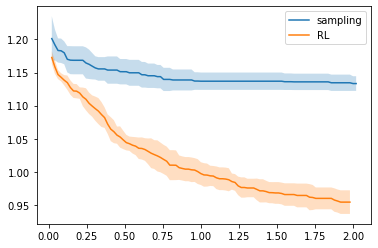

(10, 99)
(5, 97)


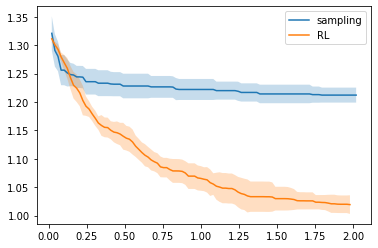

(10, 79)
(5, 77)


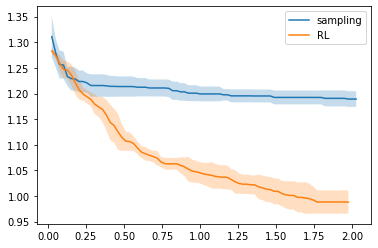

(10, 79)
(5, 77)


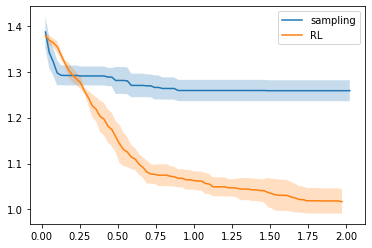

In [36]:
for min_latencies_sample, min_latencies_rl, program_id, network_id, norm in zip (best_sample_latencies, opdevRL_latencies, p_id, n_id, norm_serial_min):
    prg = programs[program_id]
    net = networks[network_id]
    
    constraints = get_placement_constraints(prg, net)
        
    
    normalized = np.array([np.array(l)/norm for l in min_latencies_sample])
    print(normalized.shape)
    mean = np.mean(normalized, axis=0)
    std = np.std(normalized, axis=0)
    x = (np.array(range(len(mean)))+1)/programs[program_id].n_operators
    plt.plot(x, mean, label='sampling' )
    plt.fill_between(x, mean + std, mean - std, alpha=.25)
    
    normalized = np.array([np.array(l)/norm for l in min_latencies_rl])
    print(normalized.shape)
    mean = np.mean(normalized, axis=0)
    std = np.std(normalized, axis=0)
    x = (np.array(range(len(mean)))+1)/programs[program_id].n_operators
    plt.plot(x, mean, label='RL' )
    plt.fill_between(x, mean + std, mean - std, alpha=.25)
    plt.legend()
    plt.show()